<a href="https://colab.research.google.com/github/nilanahar/MMAI_894_DeepLearning_Project_TeamRosedale/blob/main/MMAI_894_DeepLearning_TeamProject_ResNet50_Glove_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# =========================================
# Import Necessary Libraries
# =========================================

import pandas as pd
import numpy as np
import re
import ast
import nltk
import matplotlib.pyplot as plt

# NLTK Downloads (Run Once)
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
)
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
)
from sklearn.preprocessing import label_binarize

import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Embedding, LSTM, Bidirectional, Dense, Dropout,
    Concatenate, TimeDistributed, Reshape, Flatten, Lambda
)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import joblib
import pickle

# =========================================
# Step 1: Load and Preprocess Training Data
# =========================================

# Load your training dataset
# Load your training dataset
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Mounted at /content/drive


In [19]:
!pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.8 MB/s eta 0:00:00


In [4]:
from sklearn.model_selection import train_test_split
df_train = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Training/(1)_dfTrain_unique_2.1.joblib")
df_train, df_valid = train_test_split(df_train, test_size=0.2, random_state=42)

# Initialize stopwords set and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define a text preprocessing function
def preprocess_text(text):
    """
    Preprocesses input text by converting to lowercase, removing
    non-alphabetic characters, tokenizing, removing stopwords,
    and lemmatizing.
    """
    if pd.isnull(text):
        return ''
    # Convert text to lowercase
    text = text.lower()
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize text into words
    words = text.split()
    # Remove stopwords and lemmatize each word
    words = [lemmatizer.lemmatize(word) for word in words
             if word not in stop_words]
    # Join words back into a single string
    return ' '.join(words)

# Apply text preprocessing to the 'question' column
df_train['question_clean'] = df_train['question'].apply(preprocess_text)





In [5]:
df_train['multiple_choices_list'] = df_train['multiple_choices'].apply(
    lambda x: x if isinstance(x, list) else x.strip("[]").replace("'", "").split(", ")
)

df_valid['multiple_choices_list'] = df_valid['multiple_choices'].apply(
    lambda x: x if isinstance(x, list) else x.strip("[]").replace("'", "").split(", ")
)

In [6]:
df_train.iloc[:, 1:2049]

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
48572,1.197609,0.046220,0.144112,0.467456,0.077378,1.161129,0.960013,0.418951,0.840909,0.744916,...,1.512687,0.028692,0.066569,0.493411,0.180251,0.208375,1.467212,2.758441,0.939148,0.421000
38696,0.260141,0.141472,0.000000,2.069959,0.018433,1.228132,0.188874,0.138238,4.187469,0.292107,...,1.896816,0.037818,0.077172,0.041446,0.281143,0.960892,1.424604,2.235430,1.953497,0.393104
13611,0.449400,1.057897,0.321751,0.733854,0.012448,1.655118,0.408111,0.259265,0.764723,0.083264,...,0.420731,0.329666,0.102670,0.945508,0.014940,0.004595,1.052646,4.507308,2.480709,0.190921
35213,0.741694,1.308700,0.172705,0.591815,0.070633,0.444096,0.681609,0.305773,0.602083,0.098680,...,0.641205,0.093069,0.121194,0.969004,0.415850,0.000000,0.441840,3.833966,0.812568,0.182571
31766,1.068136,0.599810,0.445329,0.657603,0.010107,0.551988,0.027920,1.016533,0.072617,0.067725,...,0.099641,0.242064,0.002793,0.567697,0.238774,0.311013,0.552151,4.516645,0.506369,0.174714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54343,1.026126,0.028950,0.000000,1.993993,0.135983,0.683602,0.071961,0.006222,4.487733,0.000000,...,1.811754,0.217465,0.008753,0.173484,0.733333,0.701075,1.055304,2.737739,1.277116,0.003784
38158,0.612563,1.178149,0.358170,1.244002,0.756579,0.579863,0.679991,0.184435,0.482859,0.082714,...,0.386261,0.080979,0.042398,0.933653,0.150318,0.039998,0.601174,4.315222,1.450608,0.363472
860,0.490078,0.095715,0.072187,1.220713,0.158476,0.457098,0.081566,0.114910,1.847146,0.000000,...,0.744791,0.000000,0.476019,0.058613,0.863506,0.248163,0.703367,2.314135,1.156706,0.435385
15795,0.039273,0.000000,0.049426,1.009340,0.483582,1.549942,1.445162,0.128002,1.455309,0.082306,...,1.397505,0.280513,0.000000,0.137967,0.477937,0.000000,0.366958,1.256257,1.568816,0.063256


In [7]:

# Get the maximum length of multiple_choices for padding
max_choices_length = df_train['multiple_choices_list'].apply(len).max()

# Define a function to pad multiple_choices to have the same length
def pad_choices(choices, max_length):
    return choices + ['<PAD>'] * (max_length - len(choices))

# Pad the multiple_choices column
df_train['multiple_choices_list_padded'] = df_train[
    'multiple_choices_list'
].apply(lambda x: pad_choices(x, max_choices_length))

# Preprocess the padded multiple_choices
df_train['multiple_choices_clean'] = df_train[
    'multiple_choices_list_padded'
].apply(lambda choices: ' '.join(
    [preprocess_text(choice) for choice in choices]
))

# Process the 'multiple_choice_answer' column
# Assuming 'multiple_choice_answer' exists in the dataset
# and corresponds to one of the choices in 'multiple_choices_list_padded'
df_train['multiple_choice_answer_clean'] = df_train['multiple_choice_answer'].apply(preprocess_text)

# Map 'multiple_choice_answer' to the index of the choice
def map_answer_to_index(row):
    try:
        return row['multiple_choices_list_padded'].index(row['multiple_choice_answer'])
    except ValueError:
        # 如果答案不在选项中，则返回一个特殊的索引（例如-1）
        return -1

df_train['answer_index'] = df_train.apply(map_answer_to_index, axis=1)

# 过滤掉无法匹配答案的行（answer_index为-1）
df_train = df_train[df_train['answer_index'] != -1].reset_index(drop=True)

# Extract additional textual features: question length
df_train['question_tokens'] = df_train['question_clean'].apply(
    lambda x: x.split()
)
df_train['question_length'] = df_train['question_tokens'].apply(len)
df_train['question_char_length'] = df_train['question'].apply(
    lambda x: len(x) if pd.notnull(x) else 0
)

# One-Hot Encode the 'question_type' categorical feature
question_type_ohe = OneHotEncoder(
    sparse_output=False, handle_unknown='ignore'
)
question_type_encoded = question_type_ohe.fit_transform(
    df_train[['question_type']]
)

# Convert the encoded features to a DataFrame
question_type_encoded_df = pd.DataFrame(
    question_type_encoded,
    columns=question_type_ohe.get_feature_names_out(
        ['question_type']
    )
)

# Merge the encoded 'question_type' back into the main DataFrame
df_train = pd.concat(
    [df_train.reset_index(drop=True),
     question_type_encoded_df.reset_index(drop=True)],
    axis=1
)

# Process 'answer_type' if it exists
if 'answer_type' in df_train.columns:
    answer_type_ohe = OneHotEncoder(
        sparse_output=False, handle_unknown='ignore'
    )
    answer_type_encoded = answer_type_ohe.fit_transform(
        df_train[['answer_type']]
    )

    answer_type_encoded_df = pd.DataFrame(
        answer_type_encoded,
        columns=answer_type_ohe.get_feature_names_out(
            ['answer_type']
        )
    )

    # Merge the encoded 'answer_type' back into the main DataFrame
    df_train = pd.concat(
        [df_train.reset_index(drop=True),
         answer_type_encoded_df.reset_index(drop=True)],
        axis=1
    )
else:
    # If 'answer_type' is not in the dataset, create an empty DataFrame
    answer_type_encoded_df = pd.DataFrame()

# Extract image features (columns '0' to '2047' represent image features)
image_features_train = df_train.iloc[:, 1:2049]

# Check for missing values in image features
missing_values = image_features_train.isnull().sum().sum()
print(f"Total missing values in image features: {missing_values}")

# If there are missing values, impute them with the mean
if missing_values > 0:
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy='mean')
    image_features_imputed = imputer.fit_transform(image_features_train)
else:
    image_features_imputed = image_features_train.values

# Standardize the image features
scaler_img = StandardScaler()
image_features_scaled = scaler_img.fit_transform(
    image_features_imputed
)

# Use the scaled image features directly
image_features_array = image_features_scaled

# =========================================
# Step 2: Prepare Features and Labels for Training Data
# =========================================

# Extract numerical features (excluding 'answers' features)
numerical_features = df_train[[
    'question_length',
    'question_char_length'
]]

# Standardize numerical features
scaler_num = StandardScaler()
numerical_features_scaled = scaler_num.fit_transform(
    numerical_features
)

# Extract categorical features (One-Hot Encoded)
categorical_features = pd.concat(
    [question_type_encoded_df.reset_index(drop=True),
     answer_type_encoded_df.reset_index(drop=True)],
    axis=1
)

# Convert categorical features to NumPy array
categorical_features_array = categorical_features.values

# Prepare text data using shared Tokenizer
max_vocab_size = 5000
max_sequence_length = 50

# Combine all text for Tokenizer training
all_text = df_train['question_clean'] + ' ' + df_train[
    'multiple_choices_clean'
] + ' ' + df_train['multiple_choice_answer_clean']

# Initialize shared Tokenizer
tokenizer = Tokenizer(
    num_words=max_vocab_size, oov_token='<OOV>'
)
tokenizer.fit_on_texts(all_text)

# Prepare sequences for questions
sequences_question = tokenizer.texts_to_sequences(
    df_train['question_clean']
)
padded_sequences_question = pad_sequences(
    sequences_question,
    maxlen=max_sequence_length,
    padding='post'
)

# Prepare sequences for choices
def choices_to_sequences(choices_list):
    return tokenizer.texts_to_sequences(choices_list)

df_train['choices_sequences'] = df_train[
    'multiple_choices_list_padded'
].apply(choices_to_sequences)

# Pad each choice's sequence
def pad_choices_sequences(choices_sequences):
    return pad_sequences(
        choices_sequences,
        maxlen=max_sequence_length,
        padding='post'
    )

df_train['choices_padded_sequences'] = df_train[
    'choices_sequences'
].apply(pad_choices_sequences)

# Convert choices sequences to NumPy array
choices_array = np.stack(
    df_train['choices_padded_sequences'].values
)

# Update vocabulary size
vocab_size = min(
    max_vocab_size, len(tokenizer.word_index) + 1
)



Total missing values in image features: 0


In [8]:
# =========================================
# Step 3: Load and Preprocess Validation Data
# =========================================

# Load your validation dataset
df_val = df_valid

# Apply text preprocessing to the 'question' column
df_val['question_clean'] = df_val['question'].apply(preprocess_text)

df_val['multiple_choices_list'] = df_val['multiple_choices'].apply(
    lambda x: x if isinstance(x, list) else x.strip("[]").replace("'", "").split(", ")
)
# Pad the multiple_choices column
df_val['multiple_choices_list_padded'] = df_val[
    'multiple_choices_list'
].apply(lambda x: pad_choices(x, max_choices_length))

# Preprocess the padded multiple_choices
df_val['multiple_choices_clean'] = df_val[
    'multiple_choices_list_padded'
].apply(lambda choices: ' '.join(
    [preprocess_text(choice) for choice in choices]
))

# Process the 'multiple_choice_answer' column
df_val['multiple_choice_answer_clean'] = df_val['multiple_choice_answer'].apply(preprocess_text)

# Map 'multiple_choice_answer' to the index of the choice
df_val['answer_index'] = df_val.apply(map_answer_to_index, axis=1)

# 过滤掉无法匹配答案的行（answer_index为-1）
df_val = df_val[df_val['answer_index'] != -1].reset_index(drop=True)

# Extract additional textual features: question length
df_val['question_tokens'] = df_val['question_clean'].apply(
    lambda x: x.split()
)
df_val['question_length'] = df_val['question_tokens'].apply(len)
df_val['question_char_length'] = df_val['question'].apply(
    lambda x: len(x) if pd.notnull(x) else 0
)

# One-Hot Encode the 'question_type' categorical feature using the same encoder
question_type_encoded_val = question_type_ohe.transform(
    df_val[['question_type']]
)

# Convert the encoded features to a DataFrame
question_type_encoded_df_val = pd.DataFrame(
    question_type_encoded_val,
    columns=question_type_ohe.get_feature_names_out(
        ['question_type']
    )
)

# Merge the encoded 'question_type' back into the main DataFrame
df_val = pd.concat(
    [df_val.reset_index(drop=True),
     question_type_encoded_df_val.reset_index(drop=True)],
    axis=1
)

# Process 'answer_type' if it exists
if 'answer_type' in df_val.columns:
    answer_type_encoded_val = answer_type_ohe.transform(
        df_val[['answer_type']]
    )

    answer_type_encoded_df_val = pd.DataFrame(
        answer_type_encoded_val,
        columns=answer_type_ohe.get_feature_names_out(
            ['answer_type']
        )
    )

    # Merge the encoded 'answer_type' back into the main DataFrame
    df_val = pd.concat(
        [df_val.reset_index(drop=True),
         answer_type_encoded_df_val.reset_index(drop=True)],
        axis=1
    )
else:
    # If 'answer_type' is not in the dataset, create an empty DataFrame
    answer_type_encoded_df_val = pd.DataFrame()



In [9]:
# Extract image features for validation data
image_features_val = df_val.iloc[:, 1:2049]

# Check for missing values in image features
missing_values_val = image_features_val.isnull().sum().sum()
print(f"Total missing values in image features (validation): {missing_values_val}")

# If there are missing values, impute them with the mean using the same imputer
if missing_values_val > 0:
    image_features_imputed_val = imputer.transform(image_features_val)
else:
    image_features_imputed_val = image_features_val.values

# Standardize the image features using the same scaler
image_features_scaled_val = scaler_img.transform(
    image_features_imputed_val
)

# Use the scaled image features directly
image_features_array_val = image_features_scaled_val

# =========================================
# Step 4: Prepare Features and Labels for Validation Data
# =========================================

# Extract numerical features
numerical_features_val = df_val[[
    'question_length',
    'question_char_length'
]]

# Standardize numerical features using the same scaler
numerical_features_scaled_val = scaler_num.transform(
    numerical_features_val
)

# Extract categorical features (One-Hot Encoded)
categorical_features_val = pd.concat(
    [question_type_encoded_df_val.reset_index(drop=True),
     answer_type_encoded_df_val.reset_index(drop=True)],
    axis=1
)

# Convert categorical features to NumPy array
categorical_features_array_val = categorical_features_val.values

# Prepare sequences for questions
sequences_question_val = tokenizer.texts_to_sequences(
    df_val['question_clean']
)
padded_sequences_question_val = pad_sequences(
    sequences_question_val,
    maxlen=max_sequence_length,
    padding='post'
)

# Prepare sequences for choices
df_val['choices_sequences'] = df_val[
    'multiple_choices_list_padded'
].apply(choices_to_sequences)

# Pad each choice's sequence
df_val['choices_padded_sequences'] = df_val[
    'choices_sequences'
].apply(pad_choices_sequences)

# Convert choices sequences to NumPy array
choices_array_val = np.stack(
    df_val['choices_padded_sequences'].values
)

# Prepare labels: use 'answer_index' as the target
y_val = df_val['answer_index'].values
y_val = y_val.astype(np.int32)



Total missing values in image features (validation): 0


In [12]:
# Prepare labels: use 'answer_index' as the target
y_train = df_train['answer_index'].values
y_train = y_train.astype(np.int32)
y_train

array([10, 14, 10, ..., 10,  4,  1], dtype=int32)

In [14]:
# =========================================
# Step 5: Define the Model Architecture
# =========================================

# Load pre-trained GloVe embeddings
embedding_dim = 300
embedding_index = {}
embedding_file = ("/content/drive/MyDrive/Smith School of Business (MMAI)/glove.6B.300d 1.txt")
with open(embedding_file, encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coeffs

# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Define Input layers
question_input = Input(
    shape=(max_sequence_length,), name='question_input'
)
choices_input = Input(
    shape=(max_choices_length, max_sequence_length), name='choices_input'
)
image_input = Input(
    shape=(image_features_array.shape[1],), name='image_input'
)
num_input = Input(
    shape=(numerical_features_scaled.shape[1],), name='num_input'
)
cat_input = Input(
    shape=(categorical_features_array.shape[1],), name='cat_input'
)

# Shared Embedding layer
embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=False,
    name='shared_embedding'
)

# Embed question
question_embedded = embedding_layer(question_input)
question_encoded = Bidirectional(
    LSTM(64), name='question_lstm'
)(question_embedded)

# Embed and encode choices using TimeDistributed
choices_embedded = TimeDistributed(embedding_layer, name='choices_embedding')(choices_input)
choices_encoded = TimeDistributed(
    Bidirectional(LSTM(64), name='choice_lstm')
)(choices_embedded)

# Compute similarity between question and each choice
# Expand question_encoded to match choices_encoded
question_encoded_expanded = Reshape((1, 128))(question_encoded)

# Use Lambda layer to perform tiling
question_encoded_tiled = Lambda(lambda x: tf.tile(x, [1, max_choices_length, 1]))(question_encoded_expanded)

# Compute element-wise multiplication as similarity measure
similarity = tf.keras.layers.multiply([question_encoded_tiled, choices_encoded])

# Flatten similarity features
similarity_flat = TimeDistributed(
    Dense(64, activation='relu'), name='similarity_dense'
)(similarity)
similarity_flat = Flatten()(similarity_flat)

# Process image features
image_dense1 = Dense(
    512, activation='relu', name='image_dense1'
)(image_input)
image_dense2 = Dense(
    256, activation='relu', name='image_dense2'
)(image_dense1)
image_dense3 = Dense(
    128, activation='relu', name='image_dense3'
)(image_dense2)

# Process numerical features
num_dense = Dense(
    32, activation='relu', name='num_dense'
)(num_input)

# Process categorical features
cat_dense = Dense(
    32, activation='relu', name='cat_dense'
)(cat_input)

# Concatenate all features
merged_features = Concatenate(name='concatenate_layer')([
    similarity_flat,
    image_dense3,
    num_dense,
    cat_dense
])

# Add fully connected layers
dense_1 = Dense(
    64, activation='relu', name='dense_1')(merged_features)
dropout_1 = Dropout(
    0.5, name='dropout_1'
)(dense_1)
output = Dense(
    max_choices_length, activation='softmax', name='output_layer'
)(dropout_1)

# Define the model
model = Model(
    inputs=[
        question_input,
        choices_input,
        image_input,
        num_input,
        cat_input
    ],
    outputs=output
)

# Print the model summary
model.summary()

# =========================================
# Step 6: Compile and Train the Model
# =========================================

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Set up early stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=6,
    restore_best_weights=True,
    verbose=1,
    mode='max'
)


# Train the model using the entire training data
history = model.fit(
    [
        padded_sequences_question,
        choices_array,
        image_features_array,
        numerical_features_scaled,
        categorical_features_array
    ],
    y_train,
    validation_data=(
        [
            padded_sequences_question_val,
            choices_array_val,
            image_features_array_val,
            numerical_features_scaled_val,
            categorical_features_array_val
        ],
        y_val
    ),
    epochs=20,
    batch_size=256,
    callbacks=[early_stopping],
    verbose=1
)




Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ question_input            │ (None, 50)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ shared_embedding          │ (None, 50, 300)        │      1,500,000 │ question_input[0][0]   │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ question_lstm             │ (None, 128)            │        186,880 │ shared_embedding[0][0] │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ choices_input             │ (None, 18, 50)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 1, 128)         │              0 │ question_lstm[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ choices_embedding         │ (None, 18, 50, 300)    │      1,500,000 │ choices_input[0][0]    │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 18, 128)        │              0 │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_1        │ (None, 18, 128)        │        186,880 │ choices_embedding[0][… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ image_input (InputLayer)  │ (None, 2048)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_1 (Multiply)     │ (None, 18, 128)        │              0 │ lambda_1[0][0],        │
│                           │                        │                │ time_distributed_1[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ image_dense1 (Dense)      │ (None, 512)            │      1,049,088 │ image_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ similarity_dense          │ (None, 18, 64)         │          8,256 │ multiply_1[0][0]       │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ image_dense2 (Dense)      │ (None, 256)            │        131,328 │ image_dense1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ num_input (InputLayer)    │ (None, 2)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cat_input (InputLayer)    │ (None, 84)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)  

 Total params: 3,185,394 (12.15 MB)

 Trainable params: 1,685,394 (6.43 MB)

 Non-trainable params: 1,500,000 (5.72 MB)

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 56s 150ms/step - accuracy: 0.0565 - loss: 2.8995 - val_accuracy: 0.1721 - val_loss: 2.7748
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 99ms/step - accuracy: 0.2055 - loss: 2.6483 - val_accuracy: 0.3492 - val_loss: 2.1843
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 99ms/step - accuracy: 0.3301 - loss: 2.2894 - val_accuracy: 0.3992 - val_loss: 1.9868
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 99ms/step - accuracy: 0.3791 - loss: 2.1324 - val_accuracy: 0.4112 - val_loss: 1.9583
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 99ms/step - accuracy: 0.4033 - loss: 2.0324 - val_accuracy: 0.4223 - val_loss: 1.9039
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 98ms/step - accuracy: 0.4236 - loss: 1.9685 - val_accuracy: 0.4223 - val_loss: 1.8855
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 99ms/step - accuracy: 0.4392 - loss: 1.8958 - val_accuracy: 0.4281 - val_loss: 1.8543
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 98ms/step - accuracy: 0.4524 - loss: 1.8504 -

In [16]:
joblib.dump(model, "/content/drive/MyDrive/Colab Notebooks/894/SimpleModel.joblib")

['/content/drive/MyDrive/Colab Notebooks/894/SimpleModel.joblib']

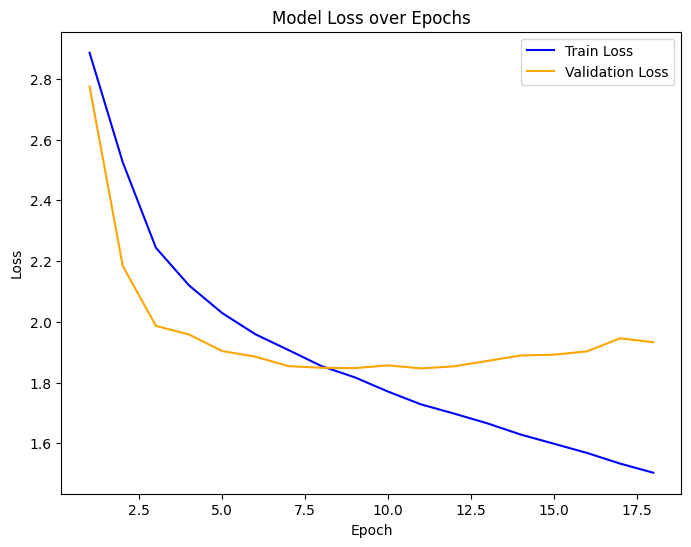

In [17]:
# Access the loss values from the history object
train_loss = history.history['loss']  # Training loss
val_loss = history.history['val_loss']  # Validation loss

# Plotting loss over epochs
plt.figure(figsize=(8, 6))
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, label='Train Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:

from tensorflow.keras.callbacks import EarlyStopping

def objective(trial):
    # Hyperparameter search space
    lstm_units = trial.suggest_int('lstm_units', 32, 128)  # Number of LSTM units
    dense_units1 = trial.suggest_int('dense_units', 64, 256)  # Number of units in fully connected layers
    dense_units2 = trial.suggest_int('dense_units2', 32, 128)  # Number of units in fully connected layers
    image_dense1_units = trial.suggest_int('image_dense1_units', 128, 512)  # Number of units in image dense layer 1
    image_dense2_units = trial.suggest_int('image_dense2_units', 128, 512)  # Number of units in image dense layer 1
    image_dense3_units = trial.suggest_int('image_dense3_units', 128, 512)  # Number of units in image dense layer 1
    num_dense_units = trial.suggest_int('num_dense_units', 32, 128)  # Number of units in numerical dense layer
    cat_dense_units = trial.suggest_int('cat_dense_units', 32, 128)  # Number of units in categorical dense layer
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)  # Dropout rate
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)  # Learning rate

    # Define Input layers
    question_input = Input(shape=(max_sequence_length,), name='question_input')
    choices_input = Input(shape=(max_choices_length, max_sequence_length), name='choices_input')
    image_input = Input(shape=(image_features_array.shape[1],), name='image_input')
    num_input = Input(shape=(numerical_features_scaled.shape[1],), name='num_input')
    cat_input = Input(shape=(categorical_features_array.shape[1],), name='cat_input')

    # Shared Embedding layer
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False, name='shared_embedding')

    # Embed question
    question_embedded = embedding_layer(question_input)
    question_encoded = Bidirectional(LSTM(lstm_units), name='question_lstm')(question_embedded)

    # Embed and encode choices using TimeDistributed
    choices_embedded = TimeDistributed(embedding_layer, name='choices_embedding')(choices_input)
    choices_encoded = TimeDistributed(Bidirectional(LSTM(lstm_units), name='choice_lstm'))(choices_embedded)

    # Compute similarity between question and choices
    question_encoded_expanded = Reshape((1, 2 * lstm_units))(question_encoded)
    question_encoded_tiled = Lambda(lambda x: tf.tile(x, [1, max_choices_length, 1]))(question_encoded_expanded)
    similarity = tf.keras.layers.multiply([question_encoded_tiled, choices_encoded])
    similarity_flat = TimeDistributed(Dense(dense_units1, activation='relu'), name='similarity_dense')(similarity)
    similarity_flat = Flatten()(similarity_flat)

    # Process image features
    image_dense1 = Dense(image_dense1_units, activation='relu', name='image_dense1')(image_input)
    image_dense2 = Dense(image_dense2_units, activation='relu', name='image_dense2')(image_dense1)
    image_dense3 = Dense(image_dense3_units, activation='relu', name='image_dense3')(image_dense2)

    # Process numerical and categorical features
    num_dense = Dense(num_dense_units, activation='relu', name='num_dense')(num_input)
    cat_dense = Dense(cat_dense_units, activation='relu', name='cat_dense')(cat_input)

    # Concatenate all features
    merged_features = Concatenate(name='concatenate_layer')([similarity_flat, image_dense3, num_dense, cat_dense])

    # Fully connected layers
    dense_1 = Dense(dense_units2, activation='relu', name='dense_1')(merged_features)
    dropout_1 = Dropout(dropout_rate, name='dropout_1')(dense_1)
    output = Dense(max_choices_length, activation='softmax', name='output_layer')(dropout_1)

    # Define and compile model
    model = Model(inputs=[question_input, choices_input, image_input, num_input, cat_input], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True, mode='max')

    # Train the model
    history = model.fit(
        [padded_sequences_question, choices_array, image_features_array, numerical_features_scaled, categorical_features_array],
        y_train,
        validation_data=([padded_sequences_question_val, choices_array_val, image_features_array_val, numerical_features_scaled_val, categorical_features_array_val], y_val),
        epochs=10,
        batch_size=256,
        callbacks=[early_stopping],
        verbose=1
    )

    # Evaluate the model
    val_accuracy = max(history.history['val_accuracy'])
    return val_accuracy

# =========================================
# Step 7: Run the Optuna Study
# =========================================

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Best hyperparameters
print("Best hyperparameters: ", study.best_params)


[I 2024-10-19 01:40:02,713] A new study created in memory with name: no-name-35fba12c-6598-4a99-9fb9-758f83ff907a


Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 91s 368ms/step - accuracy: 0.0589 - loss: 2.8980 - val_accuracy: 0.0564 - val_loss: 2.8906
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 340ms/step - accuracy: 0.0959 - loss: 2.8312 - val_accuracy: 0.3190 - val_loss: 2.2367
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 344ms/step - accuracy: 0.3299 - loss: 2.2497 - val_accuracy: 0.3956 - val_loss: 1.9413
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 343ms/step - accuracy: 0.4043 - loss: 2.0000 - val_accuracy: 0.4180 - val_loss: 1.8541
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 344ms/step - accuracy: 0.4354 - loss: 1.8764 - val_accuracy: 0.4258 - val_loss: 1.8067
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 65s 344ms/step - accuracy: 0.4541 - loss: 1.7876 - val_accuracy: 0.4328 - val_loss: 1.7913
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 340ms/step - accuracy: 0.4696 - loss: 1.7331 - val_accuracy: 0.4360 - val_loss: 1.8097
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 339ms/step - accuracy: 0.4931 - loss: 1

[I 2024-10-19 01:51:16,730] Trial 0 finished with value: 0.4359999895095825 and parameters: {'lstm_units': 126, 'dense_units': 94, 'dense_units2': 121, 'image_dense1_units': 198, 'image_dense2_units': 386, 'image_dense3_units': 383, 'num_dense_units': 94, 'cat_dense_units': 68, 'dropout_rate': 0.4263473001451986, 'learning_rate': 0.0012195690256639493}. Best is trial 0 with value: 0.4359999895095825.


Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 79s 296ms/step - accuracy: 0.0558 - loss: 2.8986 - val_accuracy: 0.0549 - val_loss: 2.8910
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 50s 266ms/step - accuracy: 0.0559 - loss: 2.8904 - val_accuracy: 0.0549 - val_loss: 2.8908
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 50s 267ms/step - accuracy: 0.0572 - loss: 2.8905 - val_accuracy: 0.0563 - val_loss: 2.8909
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 50s 266ms/step - accuracy: 0.0562 - loss: 2.8905 - val_accuracy: 0.0559 - val_loss: 2.8910
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 50s 267ms/step - accuracy: 0.0569 - loss: 2.8905 - val_accuracy: 0.0563 - val_loss: 2.8911
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 50s 266ms/step - accuracy: 0.0551 - loss: 2.8905 - val_accuracy: 0.0563 - val_loss: 2.8909


[I 2024-10-19 01:56:47,754] Trial 1 finished with value: 0.056333333253860474 and parameters: {'lstm_units': 33, 'dense_units': 194, 'dense_units2': 90, 'image_dense1_units': 283, 'image_dense2_units': 310, 'image_dense3_units': 233, 'num_dense_units': 45, 'cat_dense_units': 34, 'dropout_rate': 0.3255945646981899, 'learning_rate': 0.0034495873721366037}. Best is trial 0 with value: 0.4359999895095825.


Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 88s 339ms/step - accuracy: 0.0732 - loss: 2.8777 - val_accuracy: 0.2343 - val_loss: 2.4797
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 55s 293ms/step - accuracy: 0.2560 - loss: 2.4236 - val_accuracy: 0.3153 - val_loss: 2.1717
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 57s 303ms/step - accuracy: 0.3220 - loss: 2.1823 - val_accuracy: 0.3534 - val_loss: 2.0539
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 56s 301ms/step - accuracy: 0.3767 - loss: 2.0091 - val_accuracy: 0.3782 - val_loss: 1.9727
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 56s 297ms/step - accuracy: 0.4166 - loss: 1.8627 - val_accuracy: 0.3895 - val_loss: 1.9484
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 56s 298ms/step - accuracy: 0.4544 - loss: 1.7339 - val_accuracy: 0.3923 - val_loss: 1.9504
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 56s 296ms/step - accuracy: 0.4937 - loss: 1.5907 - val_accuracy: 0.3917 - val_loss: 1.9586
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 57s 303ms/step - accuracy: 0.5352 - loss: 1

[I 2024-10-19 02:06:47,240] Trial 2 finished with value: 0.3941666781902313 and parameters: {'lstm_units': 86, 'dense_units': 184, 'dense_units2': 118, 'image_dense1_units': 264, 'image_dense2_units': 386, 'image_dense3_units': 488, 'num_dense_units': 83, 'cat_dense_units': 46, 'dropout_rate': 0.32940968973721735, 'learning_rate': 0.00028266476401936683}. Best is trial 0 with value: 0.4359999895095825.


Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 50s 139ms/step - accuracy: 0.0556 - loss: 2.9196 - val_accuracy: 0.0555 - val_loss: 2.8910
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 120ms/step - accuracy: 0.0560 - loss: 2.8906 - val_accuracy: 0.0518 - val_loss: 2.8911
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 119ms/step - accuracy: 0.0578 - loss: 2.8905 - val_accuracy: 0.0563 - val_loss: 2.8913
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 119ms/step - accuracy: 0.0552 - loss: 2.8907 - val_accuracy: 0.0544 - val_loss: 2.8916
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 120ms/step - accuracy: 0.0574 - loss: 2.8903 - val_accuracy: 0.0573 - val_loss: 2.8909
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 120ms/step - accuracy: 0.0541 - loss: 2.8910 - val_accuracy: 0.0563 - val_loss: 2.8915
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 119ms/step - accuracy: 0.0583 - loss: 2.8905 - val_accuracy: 0.0549 - val_loss: 2.8915
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 119ms/step - accuracy: 0.0539 - loss: 2

[I 2024-10-19 02:10:15,723] Trial 3 finished with value: 0.0572500005364418 and parameters: {'lstm_units': 82, 'dense_units': 105, 'dense_units2': 35, 'image_dense1_units': 256, 'image_dense2_units': 307, 'image_dense3_units': 327, 'num_dense_units': 117, 'cat_dense_units': 107, 'dropout_rate': 0.3719359601843858, 'learning_rate': 0.008056031376533284}. Best is trial 0 with value: 0.4359999895095825.


Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 44s 138ms/step - accuracy: 0.0543 - loss: 2.8942 - val_accuracy: 0.0589 - val_loss: 2.8909
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 118ms/step - accuracy: 0.0732 - loss: 2.8777 - val_accuracy: 0.2282 - val_loss: 2.6262
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 118ms/step - accuracy: 0.2239 - loss: 2.5876 - val_accuracy: 0.2643 - val_loss: 2.3988
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 118ms/step - accuracy: 0.2714 - loss: 2.4005 - val_accuracy: 0.3034 - val_loss: 2.2794
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 118ms/step - accuracy: 0.3108 - loss: 2.2718 - val_accuracy: 0.3211 - val_loss: 2.2213
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 118ms/step - accuracy: 0.3352 - loss: 2.1803 - val_accuracy: 0.3338 - val_loss: 2.1789
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 118ms/step - accuracy: 0.3733 - loss: 2.0644 - val_accuracy: 0.3459 - val_loss: 2.1307
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 118ms/step - accuracy: 0.4009 - loss: 1

[I 2024-10-19 02:14:20,566] Trial 4 finished with value: 0.35725000500679016 and parameters: {'lstm_units': 74, 'dense_units': 212, 'dense_units2': 42, 'image_dense1_units': 385, 'image_dense2_units': 421, 'image_dense3_units': 357, 'num_dense_units': 87, 'cat_dense_units': 122, 'dropout_rate': 0.27539307705991123, 'learning_rate': 0.00012868099016859498}. Best is trial 0 with value: 0.4359999895095825.


Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 43s 133ms/step - accuracy: 0.0543 - loss: 2.8972 - val_accuracy: 0.0563 - val_loss: 2.8907
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 113ms/step - accuracy: 0.0550 - loss: 2.8903 - val_accuracy: 0.0563 - val_loss: 2.8907
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.0554 - loss: 2.8905 - val_accuracy: 0.0563 - val_loss: 2.8908
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 113ms/step - accuracy: 0.0580 - loss: 2.8903 - val_accuracy: 0.0563 - val_loss: 2.8908


[I 2024-10-19 02:16:08,018] Trial 5 finished with value: 0.056333333253860474 and parameters: {'lstm_units': 53, 'dense_units': 105, 'dense_units2': 66, 'image_dense1_units': 209, 'image_dense2_units': 434, 'image_dense3_units': 438, 'num_dense_units': 94, 'cat_dense_units': 95, 'dropout_rate': 0.4724850646998293, 'learning_rate': 0.0018412515621972962}. Best is trial 0 with value: 0.4359999895095825.


Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 42s 116ms/step - accuracy: 0.0568 - loss: 2.8940 - val_accuracy: 0.0563 - val_loss: 2.8907
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 95ms/step - accuracy: 0.0571 - loss: 2.8903 - val_accuracy: 0.0549 - val_loss: 2.8908
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 95ms/step - accuracy: 0.0573 - loss: 2.8901 - val_accuracy: 0.0549 - val_loss: 2.8908
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 95ms/step - accuracy: 0.0558 - loss: 2.8901 - val_accuracy: 0.0563 - val_loss: 2.8908


[I 2024-10-19 02:17:45,065] Trial 6 finished with value: 0.056333333253860474 and parameters: {'lstm_units': 48, 'dense_units': 111, 'dense_units2': 41, 'image_dense1_units': 349, 'image_dense2_units': 248, 'image_dense3_units': 453, 'num_dense_units': 88, 'cat_dense_units': 34, 'dropout_rate': 0.23482562742117702, 'learning_rate': 0.001461958558571838}. Best is trial 0 with value: 0.4359999895095825.


Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 44s 139ms/step - accuracy: 0.0575 - loss: 2.8927 - val_accuracy: 0.0599 - val_loss: 2.8913
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 118ms/step - accuracy: 0.1274 - loss: 2.7903 - val_accuracy: 0.2704 - val_loss: 2.3651
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 119ms/step - accuracy: 0.2804 - loss: 2.3682 - val_accuracy: 0.3182 - val_loss: 2.1968
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 118ms/step - accuracy: 0.3281 - loss: 2.1990 - val_accuracy: 0.3489 - val_loss: 2.0813
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 119ms/step - accuracy: 0.3639 - loss: 2.0612 - val_accuracy: 0.3702 - val_loss: 2.0301
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 119ms/step - accuracy: 0.3987 - loss: 1.9531 - val_accuracy: 0.3792 - val_loss: 1.9919
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 119ms/step - accuracy: 0.4361 - loss: 1.8245 - val_accuracy: 0.3868 - val_loss: 1.9969
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 118ms/step - accuracy: 0.4604 - loss: 1

[I 2024-10-19 02:21:50,874] Trial 7 finished with value: 0.38758334517478943 and parameters: {'lstm_units': 74, 'dense_units': 125, 'dense_units2': 39, 'image_dense1_units': 129, 'image_dense2_units': 390, 'image_dense3_units': 470, 'num_dense_units': 52, 'cat_dense_units': 85, 'dropout_rate': 0.21476964012756697, 'learning_rate': 0.0003025553598653551}. Best is trial 0 with value: 0.4359999895095825.


Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 40s 119ms/step - accuracy: 0.0540 - loss: 2.9014 - val_accuracy: 0.0654 - val_loss: 2.8877
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 96ms/step - accuracy: 0.1346 - loss: 2.8113 - val_accuracy: 0.2336 - val_loss: 2.5053
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 95ms/step - accuracy: 0.2451 - loss: 2.4666 - val_accuracy: 0.2708 - val_loss: 2.3027
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 96ms/step - accuracy: 0.2906 - loss: 2.2896 - val_accuracy: 0.3052 - val_loss: 2.1968
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 96ms/step - accuracy: 0.3323 - loss: 2.1667 - val_accuracy: 0.3223 - val_loss: 2.1398
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 95ms/step - accuracy: 0.3567 - loss: 2.0812 - val_accuracy: 0.3332 - val_loss: 2.1195
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 95ms/step - accuracy: 0.3875 - loss: 1.9733 - val_accuracy: 0.3413 - val_loss: 2.0938
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 95ms/step - accuracy: 0.4139 - loss: 1.8815 -

[I 2024-10-19 02:25:13,819] Trial 8 finished with value: 0.34958332777023315 and parameters: {'lstm_units': 40, 'dense_units': 129, 'dense_units2': 106, 'image_dense1_units': 496, 'image_dense2_units': 436, 'image_dense3_units': 235, 'num_dense_units': 44, 'cat_dense_units': 60, 'dropout_rate': 0.4107986144568738, 'learning_rate': 0.0001215096690629183}. Best is trial 0 with value: 0.4359999895095825.


Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 44s 140ms/step - accuracy: 0.0576 - loss: 2.8936 - val_accuracy: 0.2048 - val_loss: 2.7654
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 120ms/step - accuracy: 0.1839 - loss: 2.6973 - val_accuracy: 0.2917 - val_loss: 2.3502
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 120ms/step - accuracy: 0.2731 - loss: 2.4355 - val_accuracy: 0.3302 - val_loss: 2.2144
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 120ms/step - accuracy: 0.3130 - loss: 2.3204 - val_accuracy: 0.3704 - val_loss: 2.0948
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 120ms/step - accuracy: 0.3561 - loss: 2.1834 - val_accuracy: 0.3920 - val_loss: 2.0072
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 120ms/step - accuracy: 0.3848 - loss: 2.0754 - val_accuracy: 0.4045 - val_loss: 1.9744
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 120ms/step - accuracy: 0.4155 - loss: 1.9703 - val_accuracy: 0.4064 - val_loss: 1.9402
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 120ms/step - accuracy: 0.4298 - loss: 1

[I 2024-10-19 02:29:21,651] Trial 9 finished with value: 0.4155833423137665 and parameters: {'lstm_units': 78, 'dense_units': 248, 'dense_units2': 77, 'image_dense1_units': 188, 'image_dense2_units': 460, 'image_dense3_units': 506, 'num_dense_units': 70, 'cat_dense_units': 126, 'dropout_rate': 0.48494828454486316, 'learning_rate': 0.00031976211918082506}. Best is trial 0 with value: 0.4359999895095825.


Best hyperparameters:  {'lstm_units': 126, 'dense_units': 94, 'dense_units2': 121, 'image_dense1_units': 198, 'image_dense2_units': 386, 'image_dense3_units': 383, 'num_dense_units': 94, 'cat_dense_units': 68, 'dropout_rate': 0.4263473001451986, 'learning_rate': 0.0012195690256639493}


In [22]:
# =========================================
# Define the Final Model Architecture with Best Hyperparameters
# =========================================

# Use the best hyperparameters found by Optuna
lstm_units = 126
dense_units = 94
dense_units2 = 121
image_dense1_units = 198
image_dense2_units = 386
image_dense3_units = 383
num_dense_units = 94
cat_dense_units = 68
dropout_rate = 0.4263473001451986
learning_rate = 0.0012195690256639493

# Define Input layers
question_input = Input(shape=(max_sequence_length,), name='question_input')
choices_input = Input(shape=(max_choices_length, max_sequence_length), name='choices_input')
image_input = Input(shape=(image_features_array.shape[1],), name='image_input')
num_input = Input(shape=(numerical_features_scaled.shape[1],), name='num_input')
cat_input = Input(shape=(categorical_features_array.shape[1],), name='cat_input')

# Shared Embedding layer
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False, name='shared_embedding')

# Embed question
question_embedded = embedding_layer(question_input)
question_encoded = Bidirectional(LSTM(lstm_units), name='question_lstm')(question_embedded)

# Embed and encode choices using TimeDistributed
choices_embedded = TimeDistributed(embedding_layer, name='choices_embedding')(choices_input)
choices_encoded = TimeDistributed(Bidirectional(LSTM(lstm_units), name='choice_lstm'))(choices_embedded)

# Compute similarity between question and each choice
question_encoded_expanded = Reshape((1, 2 * lstm_units))(question_encoded)
question_encoded_tiled = Lambda(lambda x: tf.tile(x, [1, max_choices_length, 1]))(question_encoded_expanded)
similarity = tf.keras.layers.multiply([question_encoded_tiled, choices_encoded])
similarity_flat = TimeDistributed(Dense(dense_units, activation='relu'), name='similarity_dense')(similarity)
similarity_flat = Flatten()(similarity_flat)

# Process image features
image_dense1 = Dense(image_dense1_units, activation='relu', name='image_dense1')(image_input)
image_dense2 = Dense(image_dense2_units, activation='relu', name='image_dense2')(image_dense1)
image_dense3 = Dense(image_dense3_units, activation='relu', name='image_dense3')(image_dense2)

# Process numerical features
num_dense = Dense(num_dense_units, activation='relu', name='num_dense')(num_input)

# Process categorical features
cat_dense = Dense(cat_dense_units, activation='relu', name='cat_dense')(cat_input)

# Concatenate all features
merged_features = Concatenate(name='concatenate_layer')([similarity_flat, image_dense3, num_dense, cat_dense])

# Add fully connected layers
dense_1 = Dense(dense_units2, activation='relu', name='dense_1')(merged_features)
dropout_1 = Dropout(dropout_rate, name='dropout_1')(dense_1)
output = Dense(max_choices_length, activation='softmax', name='output_layer')(dropout_1)

# Define the model
model = Model(inputs=[question_input, choices_input, image_input, num_input, cat_input], outputs=output)

# Print the model summary
model.summary()

# =========================================
# Compile and Train the Final Model
# =========================================

# Compile the model with the best learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=1, mode='max')

# Train the model using the optimized hyperparameters
history = model.fit(
    [padded_sequences_question, choices_array, image_features_array, numerical_features_scaled, categorical_features_array],
    y_train,
    validation_data=([padded_sequences_question_val, choices_array_val, image_features_array_val, numerical_features_scaled_val, categorical_features_array_val], y_val),
    epochs=20,
    batch_size=256,
    callbacks=[early_stopping],
    verbose=1
)


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ question_input            │ (None, 50)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ shared_embedding          │ (None, 50, 300)        │      1,500,000 │ question_input[0][0]   │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ question_lstm             │ (None, 252)            │        430,416 │ shared_embedding[0][0] │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ choices_input             │ (None, 18, 50)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_14 (Reshape)      │ (None, 1, 252)         │              0 │ question_lstm[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ choices_embedding         │ (None, 18, 50, 300)    │      1,500,000 │ choices_input[0][0]    │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_14 (Lambda)        │ (None, 18, 252)        │              0 │ reshape_14[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_14       │ (None, 18, 252)        │        430,416 │ choices_embedding[0][… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ image_input (InputLayer)  │ (None, 2048)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_14 (Multiply)    │ (None, 18, 252)        │              0 │ lambda_14[0][0],       │
│                           │                        │                │ time_distributed_14[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ image_dense1 (Dense)      │ (None, 198)            │        405,702 │ image_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ similarity_dense          │ (None, 18, 94)         │         23,782 │ multiply_14[0][0]      │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ image_dense2 (Dense)      │ (None, 386)            │         76,814 │ image_dense1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ num_input (InputLayer)    │ (None, 2)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cat_input (InputLayer)    │ (None, 84)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_14 (Flatten) 

 Total params: 3,294,407 (12.57 MB)

 Trainable params: 1,794,407 (6.85 MB)

 Non-trainable params: 1,500,000 (5.72 MB)

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 93s 371ms/step - accuracy: 0.0699 - loss: 2.8828 - val_accuracy: 0.2726 - val_loss: 2.4215
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 65s 345ms/step - accuracy: 0.2886 - loss: 2.3832 - val_accuracy: 0.3757 - val_loss: 2.0143
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 68s 365ms/step - accuracy: 0.3845 - loss: 2.0642 - val_accuracy: 0.4072 - val_loss: 1.8844
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 65s 345ms/step - accuracy: 0.4164 - loss: 1.9274 - val_accuracy: 0.4192 - val_loss: 1.8322
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 65s 345ms/step - accuracy: 0.4425 - loss: 1.8271 - val_accuracy: 0.4232 - val_loss: 1.8273
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 66s 350ms/step - accuracy: 0.4596 - loss: 1.7479 - val_accuracy: 0.4327 - val_loss: 1.7916
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 343ms/step - accuracy: 0.4783 - loss: 1.6745 - val_accuracy: 0.4343 - val_loss: 1.8055
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 344ms/step - accuracy: 0.4951 - loss: 1

In [23]:
df_valid = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Validation/(1)_dfValid_unique_2.1.joblib")

# Load your validation dataset
df_val = df_valid

# Apply text preprocessing to the 'question' column
df_val['question_clean'] = df_val['question'].apply(preprocess_text)

df_val['multiple_choices_list'] = df_val['multiple_choices'].apply(
    lambda x: x if isinstance(x, list) else x.strip("[]").replace("'", "").split(", ")
)
# Pad the multiple_choices column
df_val['multiple_choices_list_padded'] = df_val[
    'multiple_choices_list'
].apply(lambda x: pad_choices(x, max_choices_length))

# Preprocess the padded multiple_choices
df_val['multiple_choices_clean'] = df_val[
    'multiple_choices_list_padded'
].apply(lambda choices: ' '.join(
    [preprocess_text(choice) for choice in choices]
))

# Process the 'multiple_choice_answer' column
df_val['multiple_choice_answer_clean'] = df_val['multiple_choice_answer'].apply(preprocess_text)

# Map 'multiple_choice_answer' to the index of the choice
df_val['answer_index'] = df_val.apply(map_answer_to_index, axis=1)

# 过滤掉无法匹配答案的行（answer_index为-1）
df_val = df_val[df_val['answer_index'] != -1].reset_index(drop=True)

# Extract additional textual features: question length
df_val['question_tokens'] = df_val['question_clean'].apply(
    lambda x: x.split()
)
df_val['question_length'] = df_val['question_tokens'].apply(len)
df_val['question_char_length'] = df_val['question'].apply(
    lambda x: len(x) if pd.notnull(x) else 0
)

# One-Hot Encode the 'question_type' categorical feature using the same encoder
question_type_encoded_val = question_type_ohe.transform(
    df_val[['question_type']]
)

# Convert the encoded features to a DataFrame
question_type_encoded_df_val = pd.DataFrame(
    question_type_encoded_val,
    columns=question_type_ohe.get_feature_names_out(
        ['question_type']
    )
)

# Merge the encoded 'question_type' back into the main DataFrame
df_val = pd.concat(
    [df_val.reset_index(drop=True),
     question_type_encoded_df_val.reset_index(drop=True)],
    axis=1
)

# Process 'answer_type' if it exists
if 'answer_type' in df_val.columns:
    answer_type_encoded_val = answer_type_ohe.transform(
        df_val[['answer_type']]
    )

    answer_type_encoded_df_val = pd.DataFrame(
        answer_type_encoded_val,
        columns=answer_type_ohe.get_feature_names_out(
            ['answer_type']
        )
    )

    # Merge the encoded 'answer_type' back into the main DataFrame
    df_val = pd.concat(
        [df_val.reset_index(drop=True),
         answer_type_encoded_df_val.reset_index(drop=True)],
        axis=1
    )
else:
    # If 'answer_type' is not in the dataset, create an empty DataFrame
    answer_type_encoded_df_val = pd.DataFrame()

# Extract image features for validation data
image_features_val = df_val.iloc[:, 1:2049]

# Check for missing values in image features
missing_values_val = image_features_val.isnull().sum().sum()
print(f"Total missing values in image features (validation): {missing_values_val}")

# If there are missing values, impute them with the mean using the same imputer
if missing_values_val > 0:
    image_features_imputed_val = imputer.transform(image_features_val)
else:
    image_features_imputed_val = image_features_val.values

# Standardize the image features using the same scaler
image_features_scaled_val = scaler_img.transform(
    image_features_imputed_val
)

# Use the scaled image features directly
image_features_array_val = image_features_scaled_val

# =========================================
# Step 4: Prepare Features and Labels for Validation Data
# =========================================

# Extract numerical features
numerical_features_val = df_val[[
    'question_length',
    'question_char_length'
]]

# Standardize numerical features using the same scaler
numerical_features_scaled_val = scaler_num.transform(
    numerical_features_val
)

# Extract categorical features (One-Hot Encoded)
categorical_features_val = pd.concat(
    [question_type_encoded_df_val.reset_index(drop=True),
     answer_type_encoded_df_val.reset_index(drop=True)],
    axis=1
)

# Convert categorical features to NumPy array
categorical_features_array_val = categorical_features_val.values

# Prepare sequences for questions
sequences_question_val = tokenizer.texts_to_sequences(
    df_val['question_clean']
)
padded_sequences_question_val = pad_sequences(
    sequences_question_val,
    maxlen=max_sequence_length,
    padding='post'
)

# Prepare sequences for choices
df_val['choices_sequences'] = df_val[
    'multiple_choices_list_padded'
].apply(choices_to_sequences)

# Pad each choice's sequence
df_val['choices_padded_sequences'] = df_val[
    'choices_sequences'
].apply(pad_choices_sequences)

# Convert choices sequences to NumPy array
choices_array_val = np.stack(
    df_val['choices_padded_sequences'].values
)

# Prepare labels: use 'answer_index' as the target
y_val = df_val['answer_index'].values
y_val = y_val.astype(np.int32)



Total missing values in image features (validation): 0


In [ ]:
# =========================================
# Additional Step: Plot Confusion Matrix and AUPR
# =========================================

# Plot Confusion Matrix
cm = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Compute Precision-Recall Curve and AUPR for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(max_choices_length):
    precision[i], recall[i], _ = precision_recall_curve(y_val_binarized[:, i], y_pred_probs_val[:, i])
    average_precision[i] = auc(recall[i], precision[i])

# Plot AUPR for each class
plt.figure(figsize=(10, 8))
for i in range(max_choices_length):
    plt.plot(recall[i], precision[i], label=f'Class {i} (AUPR = {average_precision[i]:0.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Area Under Precision-Recall Curve (AUPR) per Class')
plt.legend(loc='best')
plt.show()


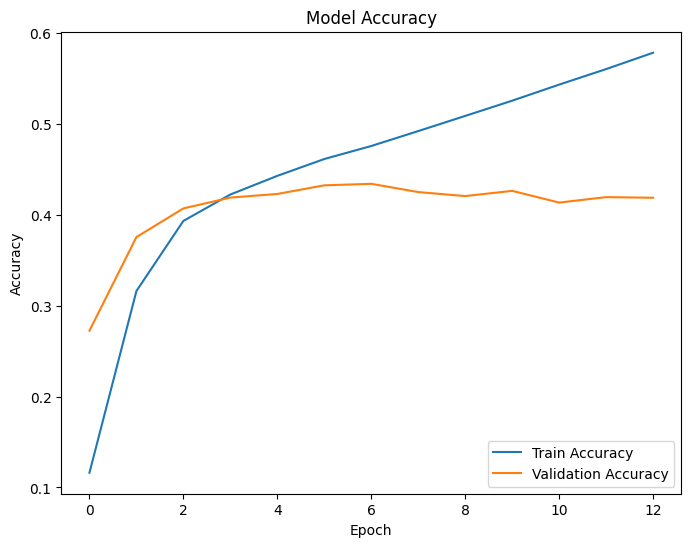

Validation Accuracy: 0.43


ROC-AUC Score on Validation Data: 0.88
              precision    recall  f1-score   support

           0       0.42      0.43      0.43      1715
           1       0.44      0.46      0.45      1671
           2       0.38      0.46      0.42      1652
           3       0.44      0.41      0.43      1681
           4       0.46      0.39      0.42      1623
           5       0.41      0.45      0.43      1657
           6       0.42      0.43      0.43      1694
           7       0.48      0.42      0.45      1687
           8       0.44      0.42      0.43      1685
           9       0.37      0.43      0.40      1641
          10       0.45      0.44      0.44      1668
          11       0.44      0.44      0.44      1673
          12       0.42      0.44      0.43      1669
          13       0.45      0.42      0.44      1656
          14       0.41      0.45      0.43      1646
          15       0.43      0.43      0.43      1641
          16       0.46      0.38      0.4

In [24]:
# =========================================
# Step 7: Evaluate the Model on Validation Data
# =========================================

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(
    [
        padded_sequences_question_val,
        choices_array_val,
        image_features_array_val,
        numerical_features_scaled_val,
        categorical_features_array_val
    ],
    y_val,
    verbose=0
)
print(f'Validation Accuracy: {val_accuracy:.2f}')

# Predict class probabilities


y_pred_probs_val = model.predict(
    [
        padded_sequences_question_val,
        choices_array_val,
        image_features_array_val,
        numerical_features_scaled_val,
        categorical_features_array_val
    ],
    verbose=0
)
# Predict class labels
y_pred_val = np.argmax(y_pred_probs_val, axis=1)

# Compute ROC-AUC score
# Note: For multi-class classification, we need to binarize the labels
y_val_binarized = label_binarize(y_val, classes=np.arange(max_choices_length))
try:
    roc_auc_val = roc_auc_score(y_val_binarized, y_pred_probs_val, average='macro', multi_class='ovo')
    print(f'ROC-AUC Score on Validation Data: {roc_auc_val:.2f}')
except ValueError as e:
    print(f'ROC-AUC computation error: {e}')

# Print classification report
print(classification_report(y_val, y_pred_val, zero_division=0))

# =========================================
# Step 8: Save the Model and Preprocessors
# =========================================

# Save the trained model
model.save('deep_learning_model.h5')

# Save the Tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Save scalers
joblib.dump(scaler_num, 'numerical_scaler.pkl')
joblib.dump(scaler_img, 'image_scaler.pkl')

# Save OneHotEncoders
joblib.dump(
    question_type_ohe, 'question_type_encoder.pkl'
)
if 'answer_type' in df_train.columns:
    joblib.dump(
        answer_type_ohe, 'answer_type_encoder.pkl'
    )

# =========================================
# End of Code
# =========================================

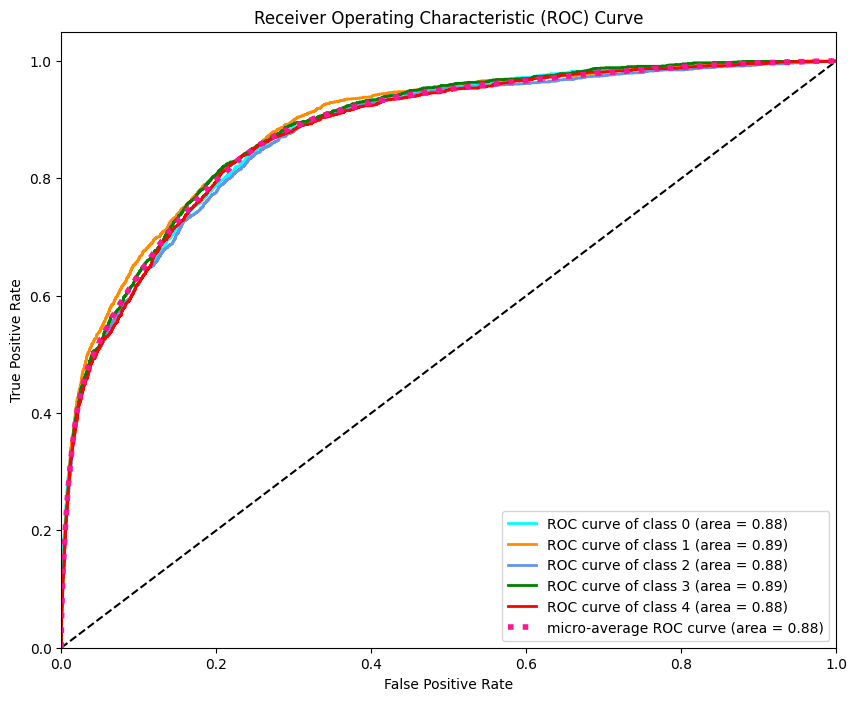

In [27]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Assuming you have y_val_binarized and y_pred_probs_val defined
# y_val_binarized: Binarized true labels for validation data
# y_pred_probs_val: Predicted probabilities for validation data

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_val_binarized.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_binarized[:, i], y_pred_probs_val[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_binarized.ravel(), y_pred_probs_val.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red']  # Adjust if more classes
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4,
         label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
